In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
#from source.utils import *
from source.preprocess import *
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

In [3]:
path = "../../Desktop/DLC_social_1/"

# Set up and design the project

In [4]:
with open('{}DLC_social_1_exp_conditions.pickle'.format(path), 'rb') as handle:
    Treatment_dict = pickle.load(handle)

In [5]:
#Which angles to compute?
bp_dict = {'B_Nose':['B_Left_ear','B_Right_ear'],
          'B_Left_ear':['B_Nose','B_Right_ear','B_Center','B_Left_flank'],
          'B_Right_ear':['B_Nose','B_Left_ear','B_Center','B_Right_flank'],
          'B_Center':['B_Left_ear','B_Right_ear','B_Left_flank','B_Right_flank','B_Tail_base'],
          'B_Left_flank':['B_Left_ear','B_Center','B_Tail_base'],
          'B_Right_flank':['B_Right_ear','B_Center','B_Tail_base'],
          'B_Tail_base':['B_Center','B_Left_flank','B_Right_flank']}

In [6]:
%%time
DLC_social_1 = project(path=path,#Path where to find the required files
                   smooth_alpha=0.85,                    #Alpha value for exponentially weighted smoothing
                   distances=['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                              'B_Right_flank','B_Tail_base'],
                   ego=False,
                   angles=True,
                   connectivity=bp_dict,
                   arena='circular',                  #Type of arena used in the experiments
                   arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                   video_format='.mp4',
                   table_format='.h5',
                   exp_conditions=Treatment_dict)

CPU times: user 2.68 s, sys: 808 ms, total: 3.49 s
Wall time: 1.21 s


# Run project

In [7]:
%%time
DLC_social_1_coords = DLC_social_1.run(verbose=True)
print(DLC_social_1_coords)
type(DLC_social_1_coords)

Loading trajectories...
Smoothing trajectories...
Computing distances...
Computing angles...
Done!
Coordinates of 47 videos across 4 conditions
CPU times: user 9.22 s, sys: 618 ms, total: 9.84 s
Wall time: 10.2 s


source.preprocess.coordinates

# Generate coords

In [8]:
%%time
ptest = DLC_social_1_coords.get_coords(center=True, polar=False, speed=0, length='00:10:00')
ptest._type

CPU times: user 808 ms, sys: 67 ms, total: 875 ms
Wall time: 837 ms


'coords'

In [9]:
%%time
dtest = DLC_social_1_coords.get_distances(speed=0, length='00:10:00')
dtest._type

CPU times: user 562 ms, sys: 411 ms, total: 973 ms
Wall time: 1.03 s


'dists'

In [10]:
%%time
atest = DLC_social_1_coords.get_angles(degrees=True, speed=0, length='00:10:00')
atest._type

CPU times: user 142 ms, sys: 85.7 ms, total: 228 ms
Wall time: 231 ms


'angles'

# Visualization playground

In [11]:
#ptest.plot_heatmaps(['B_Center', 'W_Center'], i=1)

In [12]:
#Plot animation of trajectory over time with different smoothings
#plt.plot(ptest['Day2Test13DLC']['B_Center'].iloc[:5000]['x'],
#         ptest['Day2Test13DLC']['B_Center'].iloc[:5000]['y'], label='alpha=0.85')

#plt.xlabel('x')
#plt.ylabel('y')
#plt.title('Mouse Center Trajectory using different exponential smoothings')
#plt.legend()
#plt.show()

# Dimensionality reduction playground

In [13]:
#pca = ptest.pca(4, 1000)

In [14]:
#plt.scatter(*pca[0].T)
#plt.show()

# Preprocessing playground

In [15]:
mtest = merge_tables(DLC_social_1_coords.get_coords(center=True, polar=True, length='00:10:00'))#,
#                      DLC_social_1_coords.get_distances(speed=0, length='00:10:00'),
#                      DLC_social_1_coords.get_angles(degrees=True, speed=0, length='00:10:00'))

In [16]:
#pptest = mtest.preprocess(window_size=51, filter='gaussian', sigma=10, shift=20)

In [17]:
pttest = mtest.preprocess(window_size=11, window_step=4, filter=None)
pttest.shape

(176260, 11, 28)

In [18]:
#plt.plot(pttest[2,:,2], label='normal')
#plt.plot(pptest[2,:,2], label='gaussian')
#plt.legend()
#plt.show()

# Trained models playground

### Seq 2 seq Variational Auto Encoder

In [19]:
from datetime import datetime
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.constraints import UnitNorm
from tensorflow.keras.layers import Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Lambda, LSTM
from tensorflow.keras.layers import RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from source.model_utils import *
import keras as k
import tensorflow as tf

Using TensorFlow backend.


In [20]:
NAME = 'Baseline_VAE_short'
log_dir = os.path.abspath(
    "logs/fit/{}_{}".format(NAME, datetime.now().strftime("%Y%m%d-%H%M%S"))
)
tensorboard_callback = k.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [41]:
from source.models import SEQ_2_SEQ_AE, SEQ_2_SEQ_VAE, SEQ_2_SEQ_VAEP

In [42]:
#encoder, decoder, ae = SEQ_2_SEQ_AE(pttest.shape).build()

In [43]:
#encoder, generator, vae = SEQ_2_SEQ_VAE(pttest.shape).build()

In [44]:
encoder, generator, vaep = SEQ_2_SEQ_VAEP(pttest.shape).build()

In [45]:
#ae.summary()
#vae.summary()

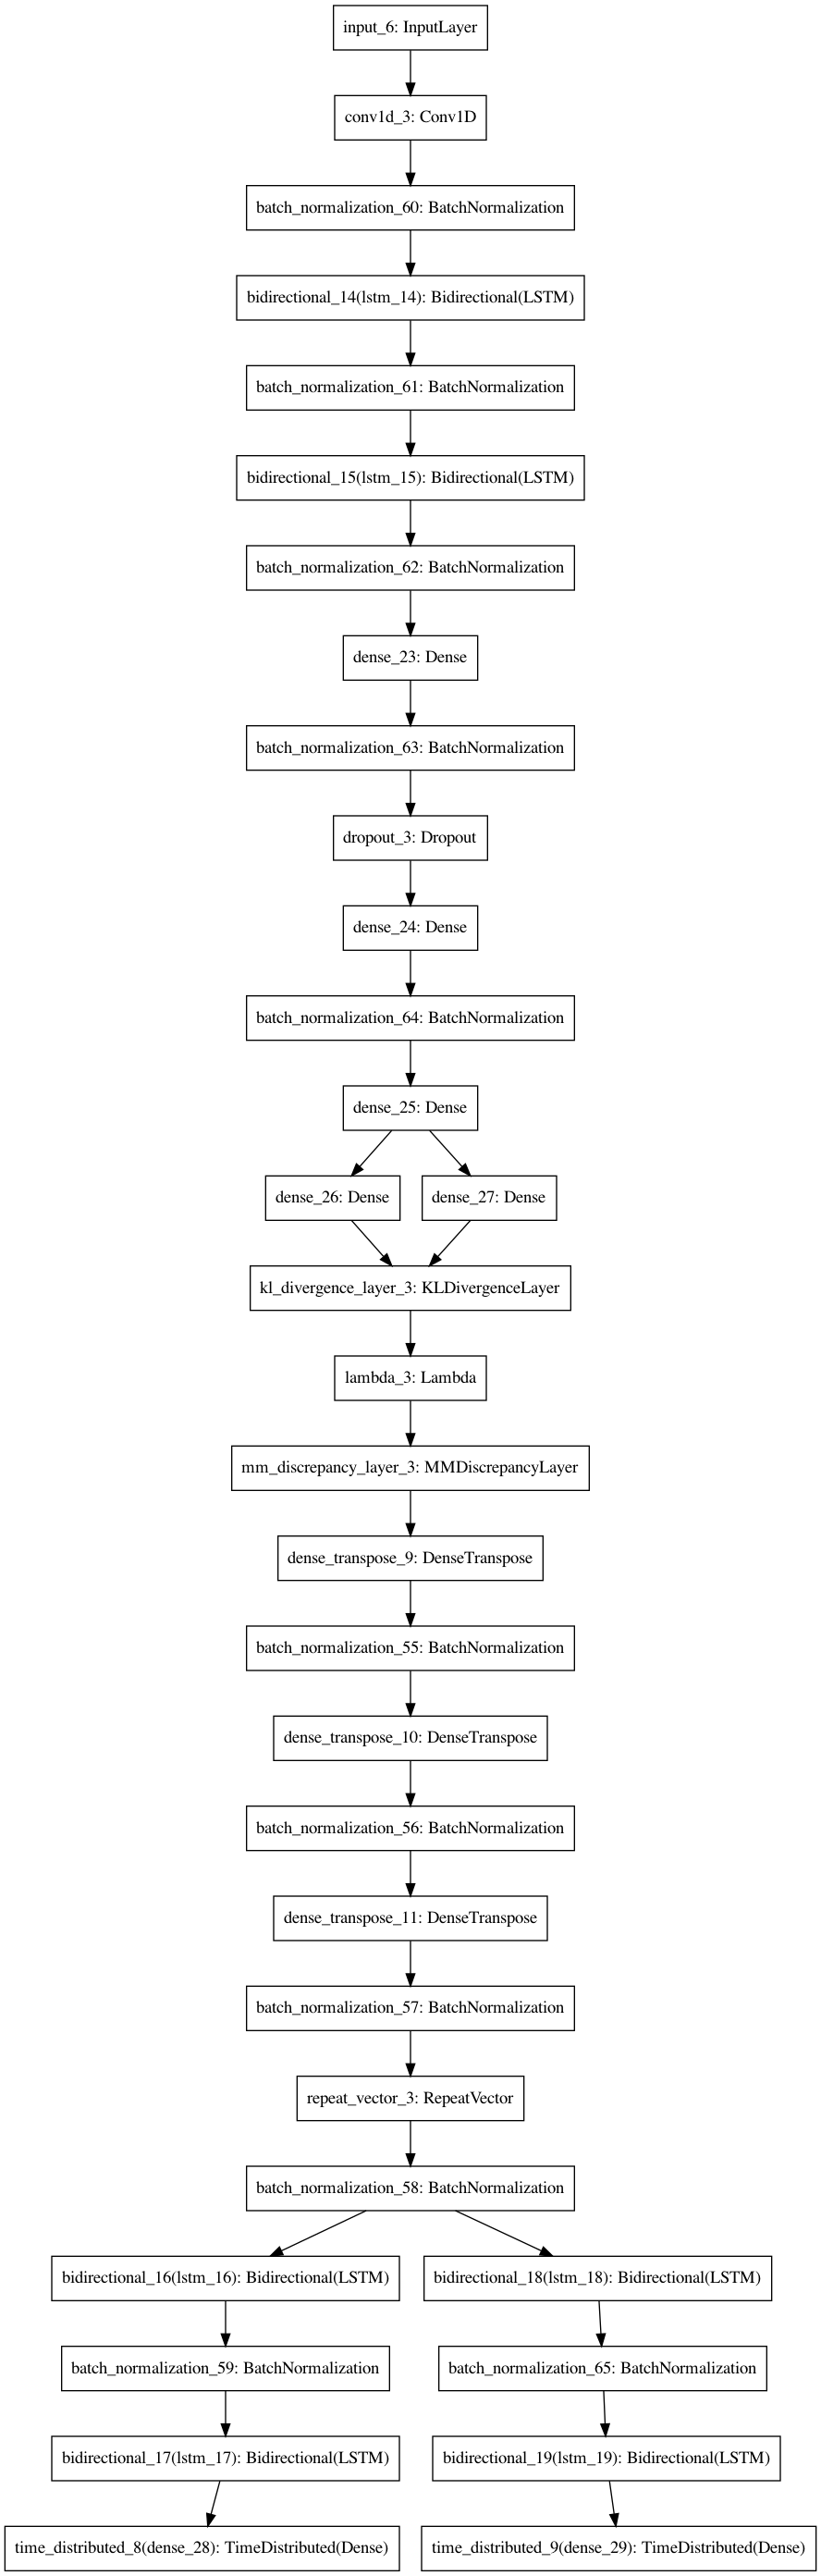

In [46]:
from tensorflow.keras.utils import plot_model
plot_model(vaep)

In [28]:
#Shuffle to check if ordered sequence makes it harder 
#for the model in the validation set!
#np.random.shuffle(pttest)
pttrain = pttest[:-20000]
pttest  = pttest[-20000:]

In [33]:
#tf.config.experimental_run_functions_eagerly(False)
history = vaep.fit(pttrain, [pttrain,pttrain], epochs=100, batch_size=512, verbose=1, validation_data=(pttest, pttest),
                 callbacks=[tensorboard_callback])

ValueError: Error when checking model target: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), for inputs ['time_distributed_2', 'time_distributed_3'] but instead got the following list of 1 arrays: [array([[[-0.41996084,  1.5374985 , -0.70832555, ...,  1.01155782,
         -0.08077491,  1.09507827],
        [-0.42441321,  1.54050855, -0.71134641, ...,  1.00592286,
         -0.0230635 ,  1.085548...